[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/miokobayashii/summerschool2022/blob/main/day03/GAN_HandWrittenDigits.ipynb)


# Introduction to Generative Adversarial Networks

## Generate handwritten digits images from noize images

- This source codes is based on the book, "GANs in Action: Deep learning with Generative Adversarial Networks" , Bok, Vladimir; Langr, Jakub. 
https://www.amazon.co.uk/GANs-Action-learning-Generative-Adversarial-ebook/dp/B09781PX97/ref=sr_1_1?crid=1VXTH6YGJ4WIL&keywords=GANs+in+Action%3A+Deep+learning+with+Generative+Adversarial+Networks&qid=1654557614&sprefix=gans+in+action+deep+learning+with+generative+adversarial+networks%2Caps%2C263&sr=8-1

### Import all the packages and libraries
"keras.datasets import mnist" means that we import the MNITST dataset of handwritten digits.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist, fashion_mnist

from keras.layers import  BatchNormalization, Dense, Flatten, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose

from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, load_model
#from keras.optimizers import Adam
from keras.optimizers import adam_v2



### Define the dimentions of our model and dataset.


In [2]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)    

z_dim = 100


### Generator
Please fill in the blanks

In [3]:
def build_generator(img_shape, z_dim):

    model = Sequential()

    # Fully connected layer
    model.add(Dense(128*4*4, input_dim=z_dim))                           
    model.add(Reshape((4, 4, 128)))

    model.add(Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', output_padding=0))
    model.add(BatchNormalization())    

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.1))

    model.add(Conv2DTranspose(32, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())    

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.1))

    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same',  activation='tanh'))

    model.compile() 
    return model

In [ ]:
# Build the Generator
generator = build_generator(img_shape, z_dim)


generator.summary()

from keras.utils.vis_utils import plot_model
plot_model(generator, to_file='model.png', show_shapes=True)


### Discriminator

In [5]:
def build_discriminator(img_shape):

    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))

    model.add(LeakyReLU(alpha=0.2))            

    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))

    #model.add(BatchNormalization())             

    model.add(LeakyReLU(alpha=0.2))            

    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))

    #model.add(BatchNormalization())             

    model.add(LeakyReLU(alpha=0.2))            

    #model.add(MaxPooling2D(pool_size=2, strides=None, padding='valid'))

    model.add(Flatten())                        

    model.add(Dense(1, activation='sigmoid'))


    return model

In [ ]:
# Build the Discriminator
discriminator = build_discriminator(img_shape)

discriminator.summary()
plot_model(discriminator, to_file='model.png', show_shapes=True)

### Build GAN

In [7]:
def build_gan(generator, discriminator):

    model = Sequential()

    # Combined Generator -> Discriminator model
    model.add(generator)
    model.add(discriminator)

    return model

In [8]:
#Compile the Discriminator
discriminator.compile(loss='binary_crossentropy',
                      optimizer=adam_v2.Adam(learning_rate=0.001, beta_1=0.5),
                      metrics=['accuracy'])


# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=adam_v2.Adam(learning_rate=0.001, beta_1=0.5))

In [ ]:
# If you want to use saved discriminator and generator models after you saved models, uncomment below and run instead of the program above.

#discriminator = load_model('/content/drive/MyDrive/Colab Notebooks/summerschool2022/day03/handwritten_discriminator.h5')
#generator = load_model('/content/drive/MyDrive/Colab Notebooks/summerschool2022/day03/handwritten_generator.h5')
#discriminator.trainable = False
#gan = build_gan(generator, discriminator)
#gan.compile(loss='binary_crossentropy', optimizer=adam_v2.Adam())


### Training 

In [9]:
losses = []
accuracies = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    # Load the MNIST dataset
    (X_train, _), (_, _) = mnist.load_data()
    #(X_train, _), (_, _) = fashion_mnist.load_data()
    # Rescale [0, 255] grayscale pixel values to [-1, 1]
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Get a random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Discriminator
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Generator
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0 or iteration == 0 :

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # Output a sample of generated image
            sample_images(generator)
            

In [10]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(z)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(image_grid_columns,image_grid_rows),
                            sharey=True,
                            sharex=True,facecolor='skyblue')

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()
  

In [11]:
# Set hyperparameters
iterations = 5000
batch_size = 256
sample_interval = 100

# Train the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

# If you want to save a generator and discriminator, uncommet the lines below.
generator.save('/content/drive/MyDrive/Colab Notebooks/summerschool2022/misc/handwritten_generator.h5')
#discriminator.trainable = True
#discriminator.compile(loss='binary_crossentropy',optimizer=adam_v2.Adam(),metrics=['accuracy'])
discriminator.save('/content/drive/MyDrive/Colab Notebooks/summerschool2022/misc/handwritten_discriminator.h5')


Output hidden; open in https://colab.research.google.com to view.

### Visualization of training process

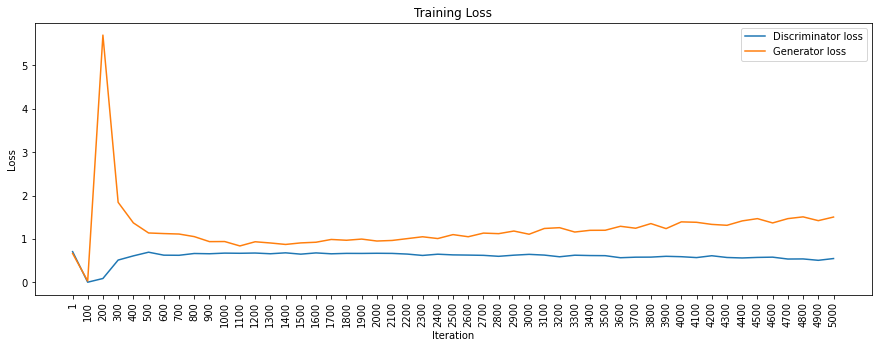

In [12]:
losses = np.array(losses)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

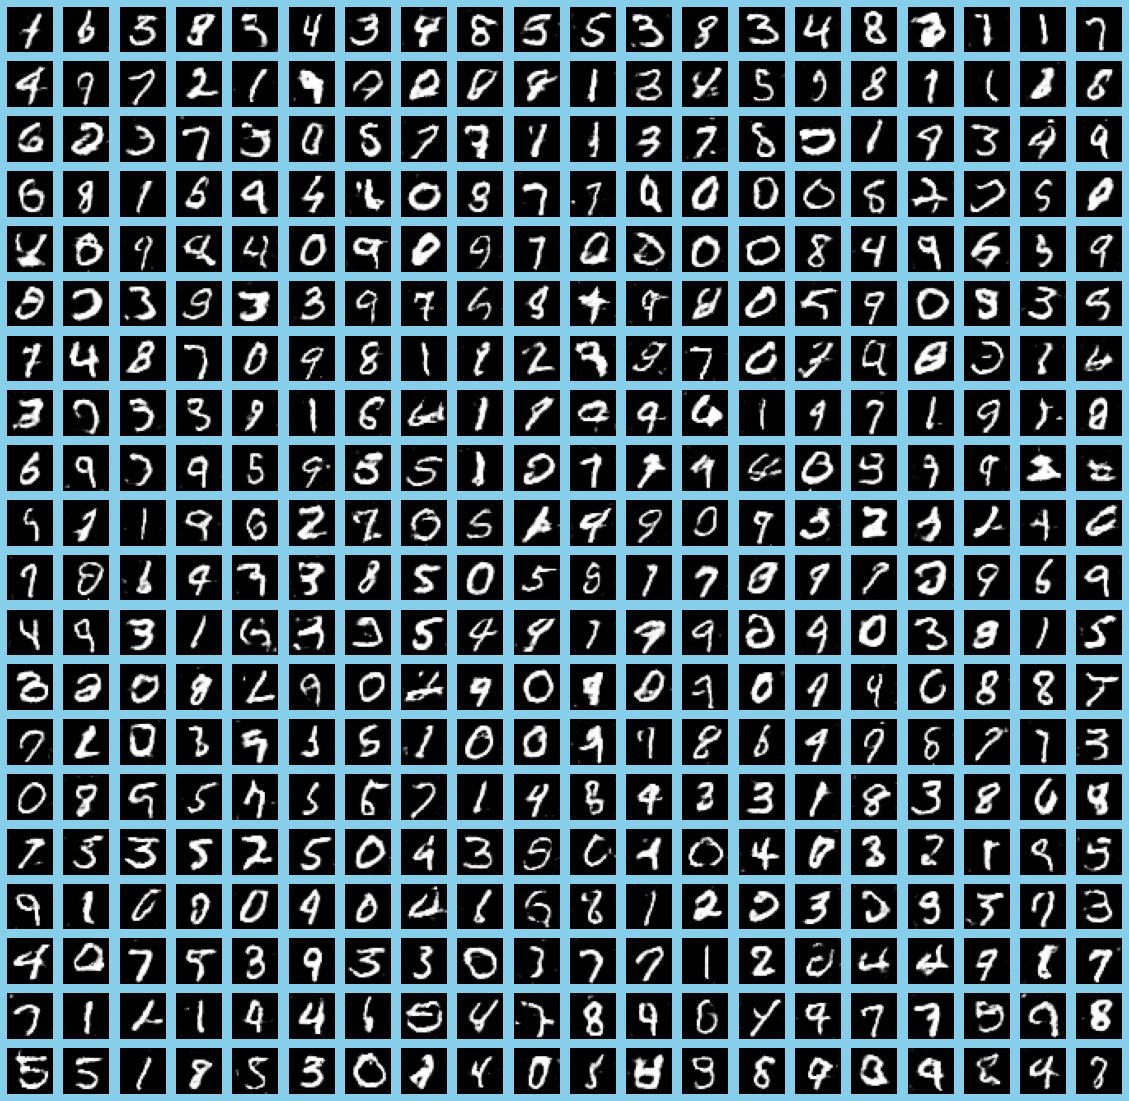

In [13]:
from keras.models import load_model
generator = load_model('/content/drive/MyDrive/Colab Notebooks/summerschool2022/misc/handwritten_generator.h5')
sample_images(generator, image_grid_rows=20, image_grid_columns=20)